In [16]:
import sys
sys.path.append('/Users/jonathontordilla/Desktop/hombom24/archive-analysis/lcls-tools-plots/lcls_tools') # path to tools 
import common.data_analysis.archiver as arch # type: ignore
from datetime import datetime
from datetime import timedelta
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

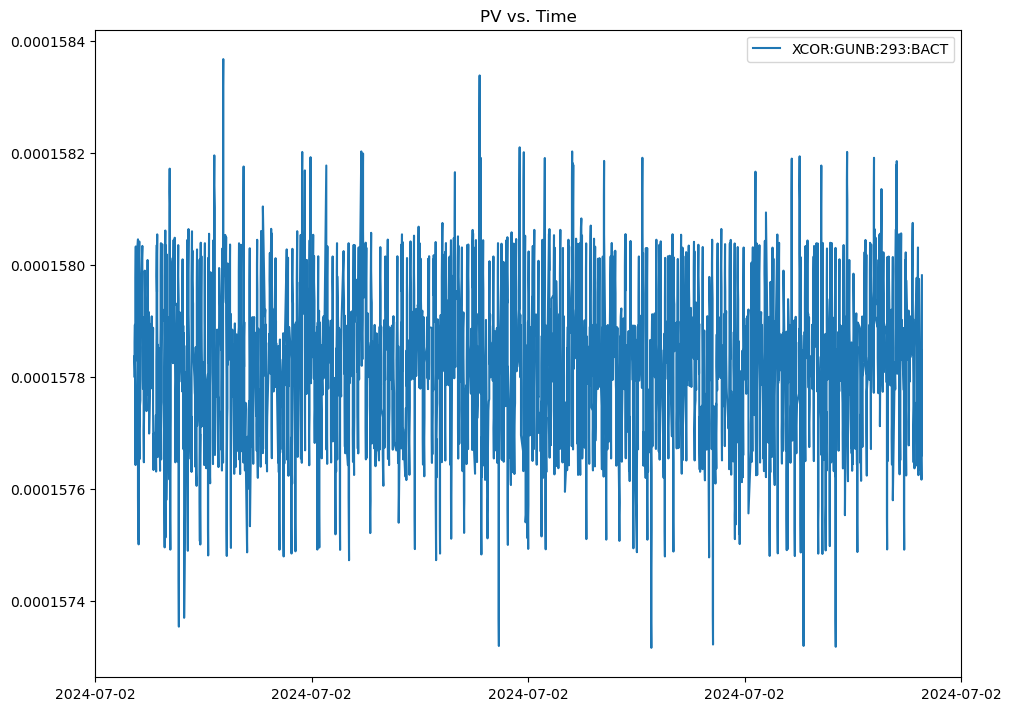

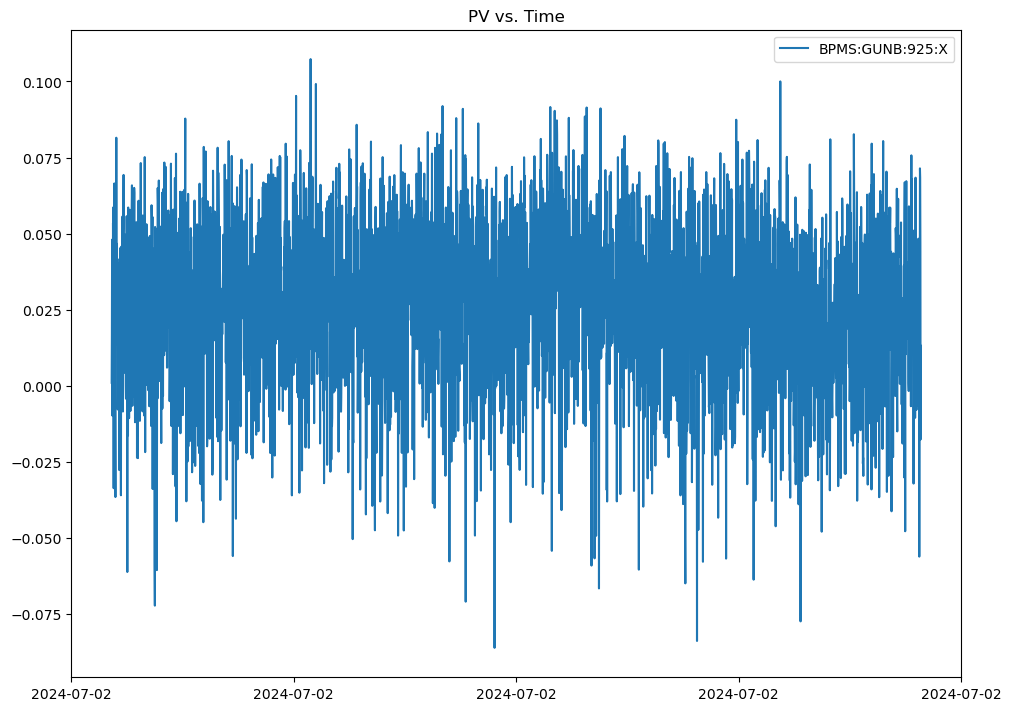

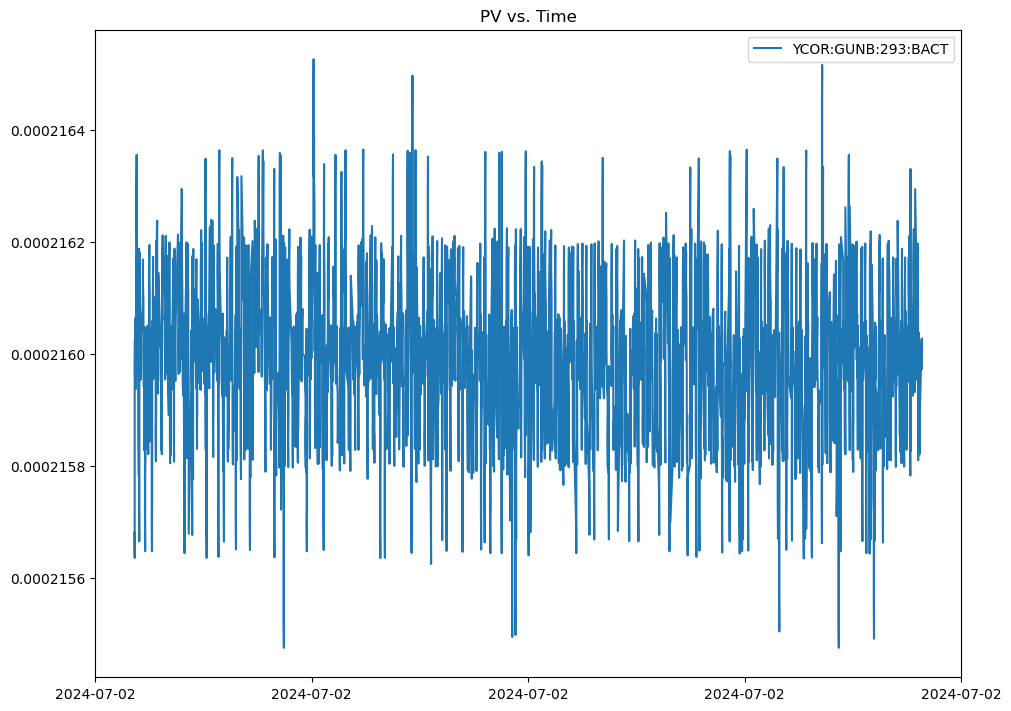

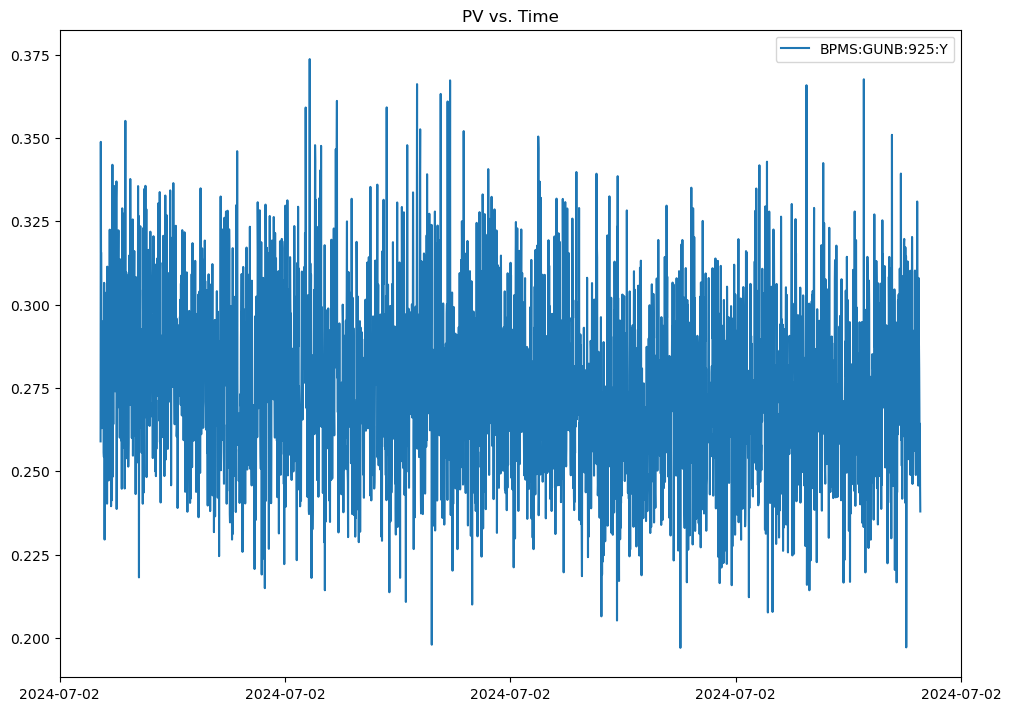

In [20]:
"""
start_end_dates = [("2024/07/01 09:00:00", "2024/07/01 12:00:00"),
                       ("2024/07/01 04:00:00", "2024/07/01 05:00:00"),
                       ("2024/07/01 12:00:00", "2024/07/01 13:00:00"),
                       ("2024/07/01 05:00:00", "2024/07/01 06:00:00"),
                       ("2024/07/02 05:00:00", "2024/07/02 06:00:00")]
"""

dates = ("2024/07/02 05:00:00", "2024/07/02 06:00:00")
xcor_pv = "XCOR:GUNB:293:BACT"
bpmx_pv = "BPMS:GUNB:925:X"
ycor_pv = "YCOR:GUNB:293:BACT"
bpmy_pv = "BPMS:GUNB:925:Y"
pv_list = [xcor_pv, bpmx_pv, ycor_pv, bpmy_pv]

for x in range(4): 
    start_date = dates[0]
    end_date = dates[1]
    start_date_obj = datetime.strptime(start_date, "%Y/%m/%d %H:%M:%S")
    end_date_obj = datetime.strptime(end_date, "%Y/%m/%d %H:%M:%S")
    
    data = arch.get_values_over_time_range([pv_list[x]], start_date_obj, end_date_obj)
    data_dict = data[pv_list[x]]
    data_timestamps = data_dict.timestamps
    data_values = data_dict.values

    df = pd.DataFrame({"timestamps": data_timestamps, pv_list[x]: data_values})
    
    fig, ax = plt.subplots(figsize=(10, 7), layout='constrained')
    ax.plot(df["timestamps"], df[pv_list[x]], label=pv_list[x])
    ax.xaxis.set_major_locator(ticker.LinearLocator(5))
    ax.set_title("PV vs. Time") 
    ax.legend() 